# はじめに

### 留意事項
* 本資料は教育・情報提供を目的としたものであり、特定の暗号資産・金融商品の売買、投資行動を推奨または勧誘するものではありません。
* 本資料に含まれる見解、分析、シミュレーション等は作成時点の情報および過去データ等に基づくものであり、その正確性・完全性を保証するものではありません。また、将来の成果・価格動向・収益等を保証するものではありません。
* 外部サービス名・製品名の記載は例示であり、主催者またはビットバンク株式会社による推奨、提携、保証を意味するものではありません。

### 初心者もくもく会について

| 項目 | 内容 |
|------|------|
| **目的** | 初心者botterが集まるきっかけを作ること |
| **形式** | りょうPさんが代表して、ほへとさんからFB（フィードバック）をもらう配信形式 |
| **参加スタイル** | もくもく会なので、それぞれ違うことをしていてOK |
| **歓迎** | 質問歓迎・冷やかし歓迎・初見歓迎 |

もともとは「もくもく作業するだけ」の会でしたが、いつの間にかほへとさんからFBを受けられる配信に進化しました。

### 関連リンク

| 種類 | リンク |
|------|--------|
| **資料** | [bitbank-botters-labo/ipynb](https://github.com/bitbankinc/bitbank-botters-labo/tree/main/ipynb) |
| **AI要約** | [bitbank-botters-labo/docs](https://github.com/bitbankinc/bitbank-botters-labo/tree/main/docs) |


---
# これまで

## コインベースプレミアム（CP）とは？

### ひとことで言うと
**CoinbaseのBTC-USD価格** と **BinanceのBTCUSDT価格** の差のこと。

### なぜ注目されるのか？
- Coinbaseは米国最大の暗号資産取引所。機関投資家・大口投資家が多く利用している
- Binanceは世界最大の取引所。個人投資家（リテール）が中心
- この2つの取引所で**同じBTCなのに価格差が生まれる**ことがある

### 価格差が意味すること（仮説）
| CP の状態 | 意味 | 市場の傾向 |
|-----------|------|-----------|
| **CP > 0（プラス）** | Coinbaseの方が高い | クリプト需要大 | 少ないUSDTでBTCが買える
| **CP < 0（マイナス）** | Binanceの方が高い | クリプトから資金が流出している  | クリプトから資金が流出していて多くのUSDTが必要になる
| **CP ≈ 0** | ほぼ同じ | 方向感なし |

### このnotebookでやること
1. CPをシグナルにした**シンプルなbot戦略**を検証する
2. **Funding Rate（FR）** と組み合わせた戦略も検証する
3. CPとFRを**標準化**して、4パターンに分類したときのリターン特性を分析する（宿題）


参考：ほへとさんのコインベースプレミアム指標の検証（GitHub）

https://github.com/i-love-profit/smart_trading/blob/main/07_%E5%8F%96%E5%BC%95%E6%89%80%E9%96%93%E3%81%AE%E4%BE%A1%E6%A0%BC%E4%B9%96%E9%9B%A2%E3%81%AE%E5%88%86%E6%9E%901_240918.ipynb （最終閲覧日：2026-02-19）

## 概要
コインベースプレミアム指標（以下CP）を使ったシンプルなロジックのbotを作っています。
- **取引対象/執行**: Binance先物のBTCUSDT（1時間足）
- **シグナル**: Premium > 0 でロング、Premium < 0 でショート、=0は見送り
- **エントリー**: シグナルが出た次の足の寄り（Binanceのopen）
- **イグジット**: 方向が変わったら次の寄りで決済し、反対方向に入り直す
- **手数料**: 片道0.05%（往復0.10%）※統計表に記載、グラフは手数料未控除
- **検証期間**: 2022-01-01 〜 2026-01-31
- **グラフ**: 上記条件で得た累積リターン（手数料未控除）
- ※注意: 先物（Binance先物）の簡易検証です。ベーシス/ファンディングは考慮していません。

---

## パラメータ設定

### このセルの説明
バックテストの**前提条件**をまとめて定義するセルです。botの検証では、まずここで「何を・いつからいつまで・どんな条件で」テストするかを決めます。

- **対象期間**: 2022-01-01 〜 2026-01-31（約4年間）
- **銘柄**: Binance先物のBTCUSDT / CoinbaseのBTC-USD
- **時間足**: 1時間足
- **手数料**: 片道0.05%（テイカー手数料を想定）
- **データの保存先**: ローカルのCSVファイルにキャッシュ（API負荷を減らすため）


In [61]:
from pathlib import Path
# Parameters
START_DATE = '2022-01-01'
END_DATE = '2026-01-31'
SYMBOL_BINANCE = 'BTCUSDT'
PRODUCT_COINBASE = 'BTC-USD'
INTERVAL = '1h'
GRANULARITY = 3600  # 1h
FEE_PCT = 0.05  # 0.05% per side (futures fee example)
BINANCE_API_BASE = 'https://fapi.binance.com'  # Binance先物

DATA_DIR = Path('notebook/coinbase_premium/data')
OUT_DIR = Path('notebook/coinbase_premium/outputs')
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('パラメータを設定しました')


パラメータを設定しました


## ライブラリ読み込み

### このセルの説明
Pythonでデータ分析をするための**道具（ライブラリ）** を準備するセルです。

- **pandas**: データを表（DataFrame）として扱うためのライブラリ。データ分析の基本
- **numpy**: 数値計算を高速に行うライブラリ
- **matplotlib**: グラフを描画するライブラリ
- **requests**: APIからデータを取得するためのHTTPライブラリ


In [62]:
import time
from datetime import datetime, timedelta, timezone
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
print('ライブラリを読み込みました')


ライブラリを読み込みました


## 日本語フォント設定

### このセルの説明
matplotlibはデフォルトで日本語を表示できないため、**日本語フォント**を設定します。OSによって使えるフォントが異なるので、候補を順番に試して最初に見つかったものを使います。

- この設定がないと、グラフのタイトルや軸ラベルが **□□□（豆腐）** になります


In [63]:
import matplotlib as mpl
from matplotlib import font_manager

jp_candidates = [
    'Hiragino Sans',
    'Hiragino Kaku Gothic ProN',
    'Yu Gothic',
    'Meiryo',
    'Noto Sans CJK JP',
    'Noto Sans JP',
    'IPAexGothic',
    'IPAPGothic',
]
available = {f.name for f in font_manager.fontManager.ttflist}
for name in jp_candidates:
    if name in available:
        mpl.rcParams['font.family'] = 'sans-serif'
        mpl.rcParams['font.sans-serif'] = [name]
        mpl.rcParams['axes.unicode_minus'] = False
        print(f'日本語フォント: {name}')
        break
else:
    print('日本語フォントが見つかりませんでした。インストール済みフォント名を指定してください。')


日本語フォント: Hiragino Sans


## データ取得関数

### このセルの説明
BinanceとCoinbaseの**APIからOHLCVデータ（始値・高値・安値・終値・出来高）を取得する関数**を定義します。

- **API**: 取引所が提供する「データの窓口」。プログラムからデータを自動取得できる
- **キャッシュ**: 一度取得したデータをCSVファイルに保存し、2回目以降はAPIを呼ばずにファイルから読み込む（APIの負荷軽減・高速化）
- **ページネーション**: APIは一度に返せるデータ量に上限があるため、繰り返しリクエストして全データを取得する仕組み

※ このセルは**関数を定義するだけ**で、実際のデータ取得は次のセルで行います。


In [64]:
def _to_dt(date_str: str) -> datetime:
    return datetime.fromisoformat(date_str).replace(tzinfo=timezone.utc)


def _binance_interval_ms(interval: str) -> int:
    if interval.endswith('m'):
        return int(interval[:-1]) * 60_000
    if interval.endswith('h'):
        return int(interval[:-1]) * 3_600_000
    if interval.endswith('d'):
        return int(interval[:-1]) * 86_400_000
    raise ValueError(f'Unsupported interval: {interval}')


def fetch_binance_klines(symbol: str, interval: str, start_date: str, end_date: str) -> pd.DataFrame:
    url = f'{BINANCE_API_BASE}/fapi/v1/klines'
    start_dt = _to_dt(start_date)
    end_dt = _to_dt(end_date)
    start_ms = int(start_dt.timestamp() * 1000)
    end_ms = int(end_dt.timestamp() * 1000)
    interval_ms = _binance_interval_ms(interval)

    rows = []
    while start_ms < end_ms:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ms,
            'endTime': end_ms,
            'limit': 1000,
        }
        resp = requests.get(url, params=params, timeout=30)
        if resp.status_code == 429:
            time.sleep(1.0)
            continue
        resp.raise_for_status()
        data = resp.json()
        if not data:
            break
        rows.extend(data)
        last_open = data[-1][0]
        start_ms = last_open + interval_ms
        time.sleep(0.2)

    if not rows:
        return pd.DataFrame()

    df = pd.DataFrame(
        rows,
        columns=[
            'open_time',
            'open',
            'high',
            'low',
            'close',
            'volume',
            'close_time',
            'quote_asset_volume',
            'trades',
            'taker_base',
            'taker_quote',
            'ignore',
        ],
    )
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df['timestamp'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    df = df.set_index('timestamp').sort_index()
    return df[['open', 'high', 'low', 'close', 'volume']]


def fetch_coinbase_candles(product: str, granularity: int, start_date: str, end_date: str) -> pd.DataFrame:
    url = f'https://api.exchange.coinbase.com/products/{product}/candles'
    start_dt = _to_dt(start_date)
    end_dt = _to_dt(end_date)

    rows = []
    chunk = timedelta(seconds=granularity * 300)
    cur = start_dt
    while cur < end_dt:
        chunk_end = min(cur + chunk, end_dt)
        params = {
            'granularity': granularity,
            'start': cur.isoformat().replace('+00:00', 'Z'),
            'end': chunk_end.isoformat().replace('+00:00', 'Z'),
        }
        resp = requests.get(url, params=params, timeout=30)
        if resp.status_code == 429:
            time.sleep(1.0)
            continue
        resp.raise_for_status()
        data = resp.json()
        if isinstance(data, list) and data:
            rows.extend(data)
        cur = chunk_end
        time.sleep(0.2)

    if not rows:
        return pd.DataFrame()

    df = pd.DataFrame(rows, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df['timestamp'] = pd.to_datetime(df['time'], unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df = df[~df.index.duplicated(keep='first')]
    return df[['open', 'high', 'low', 'close', 'volume']]


def load_or_fetch_data():
    binance_cache = DATA_DIR / f'binance_futures_{SYMBOL_BINANCE}_{INTERVAL}_{START_DATE}_{END_DATE}.csv'
    coinbase_cache = DATA_DIR / f'coinbase_{PRODUCT_COINBASE}_{INTERVAL}_{START_DATE}_{END_DATE}.csv'

    if binance_cache.exists():
        df_binance = pd.read_csv(binance_cache, parse_dates=['timestamp'], index_col='timestamp')
    else:
        df_binance = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, START_DATE, END_DATE)
        df_binance.to_csv(binance_cache, index_label='timestamp')

    if coinbase_cache.exists():
        df_coinbase = pd.read_csv(coinbase_cache, parse_dates=['timestamp'], index_col='timestamp')
    else:
        df_coinbase = fetch_coinbase_candles(PRODUCT_COINBASE, GRANULARITY, START_DATE, END_DATE)
        df_coinbase.to_csv(coinbase_cache, index_label='timestamp')

    return df_binance, df_coinbase
print('データ取得関数を定義しました')


データ取得関数を定義しました


## データ取得/読み込み

### このセルの説明
前のセルで定義した関数を実行して、**BinanceとCoinbaseの価格データを実際に取得**します。

- キャッシュ（CSVファイル）が存在すればそちらを読み込み、なければAPIから取得します
- 取得結果として、Binanceの1時間足データの先頭5行を表示します
- ここで得られるデータが、以降すべての分析のベースになります


In [65]:
print('データを取得/読み込み中...')
df_binance, df_coinbase = load_or_fetch_data()
display_df = df_binance.rename(columns={
    'open': '始値',
    'high': '高値',
    'low': '安値',
    'close': '終値',
    'volume': '出来高'
})
display_df.head()


データを取得/読み込み中...


,始値,高値,安値,終値,出来高
timestamp,,,,,
2022-01-01 00:00:00+00:00,46210.57,46729.73,46210.55,46650.01,8957.465
2022-01-01 01:00:00+00:00,46650.00,46944.56,46570.34,46766.78,7276.249
2022-01-01 02:00:00+00:00,46767.44,46917.87,46709.44,46796.14,4478.713
2022-01-01 03:00:00+00:00,46796.15,46888.00,46746.32,46789.56,4208.992
2022-01-01 04:00:00+00:00,46789.55,46868.74,46605.00,46690.81,6149.298


## シグナル生成とバックテスト

### このセルの説明
**Coinbase Premium（CP）の符号をシグナルにした、最もシンプルな戦略**のバックテストを行います。

### 戦略ロジック
1. 各バーで `CP = Coinbase終値 − Binance終値` を計算
2. **CP > 0 → ロング（買い）**、**CP < 0 → ショート（売り）**、**CP = 0 → 見送り**
3. シグナルが出た**次の足の始値（open）** でエントリー（＝先読みバイアスの防止）
4. 方向が変わったら次の寄りで決済し、反対方向に入り直す
5. 手数料（片道0.05%）を控除してリターンを計算

### ポイント
- `shift(1)` でポジションを1本ずらす → **「今のシグナルで次のバーに入る」** を再現
- `(1 + ret).cumprod()` で**累積リターン**を計算 → 1.0スタートで、2.0なら元本の2倍


In [66]:
print('シグナル生成とバックテストを実行中...')
df = df_binance.copy()
df = df.rename(columns={'open': 'binance_open', 'close': 'binance_close'})
df['coinbase_close'] = df_coinbase['close']
df = df.dropna(subset=['binance_open', 'binance_close', 'coinbase_close']).copy()

# Premium as absolute difference (sign matches ratio-based premium)
df['coinbase_premium'] = df['coinbase_close'] - df['binance_close']
df['signal'] = np.sign(df['coinbase_premium']).astype(float)

# Entry at next open
df['next_open'] = df['binance_open'].shift(-1)
df['position'] = df['signal'].shift(1).fillna(0)
price_rel = df['next_open'] / df['binance_open']
df['open_ret'] = np.where(
    df['position'] == 1, price_rel - 1,
    np.where(df['position'] == -1, (1 / price_rel) - 1, 0.0)
)
df = df.dropna(subset=['open_ret']).copy()

fee_rate = FEE_PCT / 100.0
turnover = (df['position'] - df['position'].shift(1).fillna(0)).abs()
df['strategy_ret'] = df['open_ret'] - turnover * fee_rate
df['equity'] = (1 + df['strategy_ret']).cumprod()

# 手数料なし版（グラフ表示用）
df['equity_nofee'] = (1 + df['open_ret']).cumprod()

view = df[['binance_open', 'coinbase_close', 'coinbase_premium', 'signal', 'position', 'strategy_ret', 'equity']].copy()
view.columns = ['Binance始値', 'Coinbase終値', 'Premium差', 'シグナル', 'ポジション', '戦略リターン', '累積リターン']
view.tail()


シグナル生成とバックテストを実行中...


,Binance始値,Coinbase終値,Premium差,シグナル,ポジション,戦略リターン,累積リターン
timestamp,,,,,,,
2026-01-30 19:00:00+00:00,83897.3,84115.00,-85.00,-1.0,-1.0,-0.003594,2.592209
2026-01-30 20:00:00+00:00,84199.9,83738.00,-152.30,-1.0,-1.0,0.003691,2.601776
2026-01-30 21:00:00+00:00,83890.3,84145.85,-94.45,-1.0,-1.0,-0.004155,2.590966
2026-01-30 22:00:00+00:00,84240.3,84085.64,-105.46,-1.0,-1.0,0.000584,2.592480
2026-01-30 23:00:00+00:00,84191.1,84110.99,-100.41,-1.0,-1.0,-0.000241,2.591855


## トレード集計・指標算出

### このセルの説明
バックテスト結果を**「トレード（取引）単位」で集計し、パフォーマンス指標を算出**します。

### 算出する指標
| 指標 | 意味 |
|------|------|
| **総リターン%** | 検証期間全体でどれだけ儲かったか（または損したか） |
| **取引回数** | エントリー〜イグジットを1トレードとしたときの回数 |
| **勝率%** | 全トレードのうち、利益が出たトレードの割合 |
| **最大DD%** | 最大ドローダウン。ピークからの最大の下落幅（＝最悪の含み損）|

### ポイント
- 勝率が低くても、**勝ちトレードの利益が大きければ**トータルでプラスになる
- 最大DDが大きいと、**途中で精神的にもたない**（実運用で重要な指標）


In [67]:
print('トレード集計・指標算出中...')
def build_trade_list(df_in: pd.DataFrame) -> pd.DataFrame:
    trades = []
    current = None

    for ts, row in df_in.iterrows():
        pos = row['position']
        price = row['binance_open']
        if current is None:
            if pos != 0:
                current = {'entry_time': ts, 'entry_price': price, 'direction': pos}
            continue

        if pos == 0 or pos != current['direction']:
            entry_price = current['entry_price']
            direction = current['direction']
            exit_price = price
            gross_return = (exit_price / entry_price - 1) if direction == 1 else (entry_price / exit_price - 1)
            net_return = gross_return - (FEE_PCT / 100.0) * 2
            trades.append({
                'entry_time': current['entry_time'],
                'exit_time': ts,
                'direction': int(direction),
                'entry_price': entry_price,
                'exit_price': exit_price,
                'gross_return': gross_return,
                'net_return': net_return,
            })
            current = None
            if pos != 0:
                current = {'entry_time': ts, 'entry_price': price, 'direction': pos}

    return pd.DataFrame(trades)


def summarize(df_in: pd.DataFrame, trades_in: pd.DataFrame) -> dict:
    if df_in.empty:
        return {'total_return': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'max_dd': 0.0}

    equity = df_in['equity'].copy()
    total_return = equity.iloc[-1] - 1
    running_max = equity.cummax()
    drawdown = (equity - running_max) / running_max
    max_dd = drawdown.min()

    if trades_in.empty:
        win_rate = 0.0
        num_trades = 0
    else:
        win_rate = (trades_in['net_return'] > 0).mean()
        num_trades = len(trades_in)

    return {
        'total_return': total_return,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'max_dd': max_dd,
    }


trades = build_trade_list(df)
summary = summarize(df, trades)
summary_jp = {
    '総リターン%': summary['total_return'] * 100,
    '取引回数': summary['num_trades'],
    '勝率%': summary['win_rate'] * 100,
    '最大DD%': summary['max_dd'] * 100,
}
summary_jp


トレード集計・指標算出中...


{'総リターン%': np.float64(159.18549881026638),
 '取引回数': 2000,
 '勝率%': np.float64(38.75),
 '最大DD%': np.float64(-52.94751281612551)}

## 結果テーブル

### このセルの説明
前のセルで算出したパフォーマンス指標を、**日本語の見やすい表形式**で表示します。イベント時の画面共有で、参加者がすぐに結果を理解できるようにするためです。


In [68]:
print('結果テーブルを作成中...')
summary_df = pd.DataFrame([
    {
        '戦略': 'CoinbasePremium_V10_Futures',
        '総リターン%': summary['total_return'] * 100,
        '取引回数': summary['num_trades'],
        '勝率%': summary['win_rate'] * 100,
        '最大DD%': summary['max_dd'] * 100,
    }
])
summary_df


結果テーブルを作成中...


,戦略,総リターン%,取引回数,勝率%,最大DD%
0,CoinbasePremium_V10_Futures,159.185499,2000,38.75,-52.947513


## 累積リターンのグラフ

### このセルの説明
CP戦略の累積リターンを**時系列グラフで可視化**します。

### グラフの見方
- **縦軸（累積リターン）**: 1.0 = 元本そのまま、2.0 = 2倍（+100%）、3.0 = 3倍（+200%）…
- **横軸**: 時間（2022年〜2026年）
- 右肩上がりなら戦略が機能している、横ばいや右肩下がりなら機能していない

### 検証条件（おさらい）
- 取引: Binance先物 BTCUSDT（1時間足）
- シグナル: CP > 0 でロング、CP < 0 でショート
- 約定: シグナル発生の次の足の始値
- 手数料: グラフは未控除（統計表に手数料なし/ありの両方を記載）
- ※ベーシス/ファンディングは未考慮


累積リターングラフを描画中...


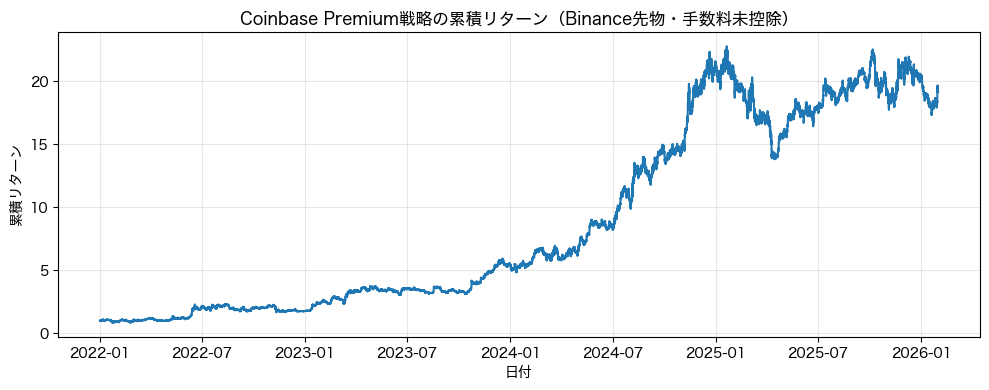

In [69]:
print('累積リターングラフを描画中...')
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['equity_nofee'], label='累積リターン（手数料なし）')
plt.title('Coinbase Premium戦略の累積リターン（Binance先物・手数料未控除）')
plt.xlabel('日付')
plt.ylabel('累積リターン')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### CSV出力


In [70]:
print('CSVを出力中...')
out_equity = OUT_DIR / 'coinbase_premium_v10_futures_equity.csv'
out_trades = OUT_DIR / 'coinbase_premium_v10_futures_trades.csv'
out_summary = OUT_DIR / 'coinbase_premium_v10_futures_summary.csv'

df[['binance_open', 'coinbase_premium', 'signal', 'position', 'strategy_ret', 'equity']].to_csv(
    out_equity, index_label='timestamp'
)
trades.to_csv(out_trades, index=False)
summary_df.to_csv(out_summary, index=False)

out_equity, out_trades, out_summary


CSVを出力中...


(PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v10_futures_equity.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v10_futures_trades.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v10_futures_summary.csv'))

## 組み合わせる戦略

### このセクションの説明
CP戦略の次のステップとして、**Funding Rate（FR）を使った別の戦略**を検証し、さらにCPとFRを**組み合わせた戦略**も試します。

### Funding Rate（FR）とは？
- Binance先物で**8時間ごとに発生する資金調達率**
- FR > 0: ロングがショートに支払う → ロングが多い（楽観的な市場）
- FR < 0: ショートがロングに支払う → ショートが多い（悲観的な市場）
- FRがマイナスのときにロングする = **「悲観的な市場で逆張りで買う」** という発想


* FR逆張り戦略（ロングのみ）
   - 戦略ロジック
      - エントリー: Funding Rate < 0%（マイナス転換）
      - エグジット: Funding Rate >= 0.01%（0.0001）
      - 約定タイミング：シグナル発生後、次バーのopen価格
      * 注文タイプ：テイカー
   * 検証条件
      - 時間足：1時間足
      - FR取得間隔：8時間ごと
   * ポジション管理
      - ポジション方向：ロングのみ
      - レバレッジ：1倍

In [71]:
print('V13: FR逆張り戦略（ロングのみ）を実行中...')

# Funding Rate取得関数（Binance Futures）
def fetch_binance_funding_rate(symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
   url = f'{BINANCE_API_BASE}/fapi/v1/fundingRate'
   start_dt = _to_dt(start_date)
   end_dt = _to_dt(end_date)
   start_ms = int(start_dt.timestamp() * 1000)
   end_ms = int(end_dt.timestamp() * 1000)

   rows = []
   while start_ms < end_ms:
       params = {
           'symbol': symbol,
           'startTime': start_ms,
           'endTime': end_ms,
           'limit': 1000,
       }
       resp = requests.get(url, params=params, timeout=30)
       if resp.status_code == 429:
           time.sleep(1.0)
           continue
       resp.raise_for_status()
       data = resp.json()
       if not data:
           break
       rows.extend(data)
       last_time = int(data[-1]['fundingTime'])
       start_ms = last_time + 1
       time.sleep(0.2)

   if not rows:
       return pd.DataFrame()

   df = pd.DataFrame(rows)
   df['fundingRate'] = df['fundingRate'].astype(float)
   df['funding_time'] = pd.to_datetime(df['fundingTime'], unit='ms', utc=True)
   df = df.set_index('funding_time').sort_index()
   return df[['fundingRate']]


def load_or_fetch_funding():
   funding_cache = DATA_DIR / f'binance_funding_{SYMBOL_BINANCE}_{START_DATE}_{END_DATE}.csv'
   if funding_cache.exists():
       df_funding = pd.read_csv(funding_cache, parse_dates=['funding_time'], index_col='funding_time')
   else:
       df_funding = fetch_binance_funding_rate(SYMBOL_BINANCE, START_DATE, END_DATE)
       df_funding.to_csv(funding_cache, index_label='funding_time')

   if 'funding_time' in df_funding.columns:
       df_funding['funding_time'] = pd.to_datetime(df_funding['funding_time'], utc=True, errors='coerce')
       df_funding = df_funding.set_index('funding_time')

   if not isinstance(df_funding.index, pd.DatetimeIndex):
       df_funding.index = pd.to_datetime(df_funding.index, utc=True, errors='coerce')
   else:
       if df_funding.index.tz is None:
           df_funding.index = df_funding.index.tz_localize('UTC')
       else:
           df_funding.index = df_funding.index.tz_convert('UTC')

   df_funding = df_funding[~df_funding.index.isna()].sort_index()
   return df_funding

funding_df = load_or_fetch_funding()

# Base data (Binance)
df = df_binance.copy()
df = df.rename(columns={'open': 'binance_open', 'close': 'binance_close'})
df = df.dropna(subset=['binance_open', 'binance_close']).copy()

# Funding alignment (ffill only; lookahead avoided by FR lag & position shift)
df['funding_rate'] = funding_df['fundingRate'].reindex(df.index, method='ffill')
df['is_funding_event'] = df.index.isin(funding_df.index)
df['funding_rate_event'] = funding_df['fundingRate'].reindex(df.index)
df = df.dropna(subset=['funding_rate']).copy()

# FR lagged (look-ahead avoidance)
df['fr_lagged'] = df['funding_rate'].shift(1)

# State machine: long when FR<0, exit when FR>=0.01%
FR_EXIT_LEVEL = 0.0001  # 0.01%
signal = pd.Series(0.0, index=df.index)
pos = 0
for i, fr in enumerate(df['fr_lagged']):
   if pd.isna(fr):
       signal.iloc[i] = pos
       continue
   if pos == 0 and fr < 0:
       pos = 1
   elif pos == 1 and fr >= FR_EXIT_LEVEL:
       pos = 0
   signal.iloc[i] = pos

# Entry at next open
df['signal'] = signal
df['next_open'] = df['binance_open'].shift(-1)
df['position'] = df['signal'].shift(1).fillna(0)
price_rel = df['next_open'] / df['binance_open']
# Linear USDT-M futures return
df['open_ret'] = df['position'] * (price_rel - 1.0)
df['open_ret'] = df['open_ret'].fillna(0.0)
df = df.dropna(subset=['open_ret']).copy()

fee_rate = FEE_PCT / 100.0
turnover = (df['position'] - df['position'].shift(1).fillna(0)).abs()
# Funding PnL (event only)
df['funding_ret'] = np.where(
   df['is_funding_event'],
   -df['position'] * df['funding_rate_event'],
   0.0
)
df['funding_ret'] = df['funding_ret'].fillna(0.0)

# Total return
df['strategy_ret'] = df['open_ret'] + df['funding_ret'] - turnover * fee_rate
df['equity'] = (1 + df['strategy_ret']).cumprod()

# 手数料なし版（グラフ表示用）
df['ret_nofee'] = df['open_ret'] + df['funding_ret']
df['equity_nofee'] = (1 + df['ret_nofee']).cumprod()

# Summary
trades_fr = build_trade_list(df)
summary_fr = summarize(df, trades_fr)
summary_fr_df = pd.DataFrame([
    {
        '戦略': 'FR_Contrarian_LongOnly_V13',
        '総リターン%': summary_fr['total_return'] * 100,
        '取引回数': summary_fr['num_trades'],
        '勝率%': summary_fr['win_rate'] * 100,
        '最大DD%': summary_fr['max_dd'] * 100,
    }
])

summary_fr_df


V13: FR逆張り戦略（ロングのみ）を実行中...


,戦略,総リターン%,取引回数,勝率%,最大DD%
0,FR_Contrarian_LongOnly_V13,156.732769,71,61.971831,-28.208827


## FR逆張り戦略の累積リターン

### このセルの説明
FR逆張り戦略（ロングのみ）の累積リターンを**グラフで可視化**します。CP戦略のグラフと見比べて、異なる戦略の特性の違いを確認しましょう。


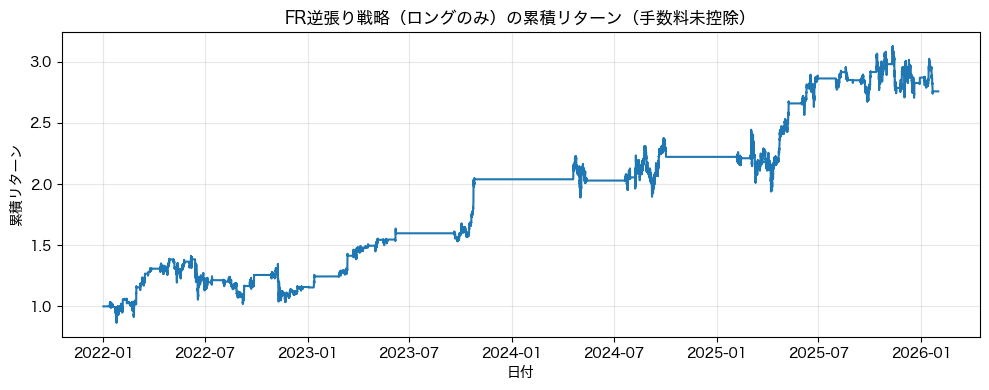

In [72]:
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['equity_nofee'], label='FR逆張り（ロングのみ・手数料なし）')
plt.title('FR逆張り戦略（ロングのみ）の累積リターン（手数料未控除）')
plt.xlabel('日付')
plt.ylabel('累積リターン')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### FR逆張り戦略のCSV出力


In [73]:
out_fr_equity = OUT_DIR / 'coinbase_premium_v13_fr_contrarian_equity.csv'
out_fr_trades = OUT_DIR / 'coinbase_premium_v13_fr_contrarian_trades.csv'
out_fr_summary = OUT_DIR / 'coinbase_premium_v13_fr_contrarian_summary.csv'

df[['binance_open', 'funding_rate', 'fr_lagged', 'signal', 'position', 'funding_ret', 'strategy_ret', 'equity']].to_csv(
    out_fr_equity, index_label='timestamp'
)
trades_fr.to_csv(out_fr_trades, index=False)
summary_fr_df.to_csv(out_fr_summary, index=False)

out_fr_equity, out_fr_trades, out_fr_summary


(PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_contrarian_equity.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_contrarian_trades.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_contrarian_summary.csv'))

## FR×Premium 組み合わせ（比較）

### このセルの説明
CPとFRを**組み合わせた戦略**を2パターン検証し、単独戦略と比較します。

### 2つの組み合わせ方
| 戦略 | ロジック | 発想 |
|------|---------|------|
| **A: FR主導 + CP補助** | FR < 0 かつ CP > 0 でロング | 悲観市場で大口が買ってるときだけ入る |
| **B: CP主導 + FR補助** | FRがマイナス転換 かつ CP > 0 でロング | 大口が買ってる状態で、FRが悲観に転じたタイミングで入る |

### 技術的なポイント
- **FR判定**: `FR_lagged = FR.shift(1)` で先読みバイアスを回避
- **Premium条件**: `premium_pct > 0`（符号のみで判定）
- 2つのシグナルを組み合わせると**取引回数は減る**が、**精度が上がる可能性**がある


In [74]:
print('V13: FR×Premium 組み合わせを実行中...')

# Ensure base_df / funding_df exist
if 'df_binance' not in globals():
    raise ValueError('df_binance がありません。上のセルを実行してください。')

if 'funding_df' not in globals():
    funding_df = load_or_fetch_funding()

# Base data
base_df = df_binance.copy()
base_df = base_df.rename(columns={'open': 'binance_open', 'close': 'binance_close'})
base_df = base_df.dropna(subset=['binance_open', 'binance_close']).copy()

# Funding alignment (ffill only; lookahead avoided by FR lag & position shift)
base_df['funding_rate'] = funding_df['fundingRate'].reindex(base_df.index, method='ffill')
base_df['is_funding_event'] = base_df.index.isin(funding_df.index)
base_df['funding_rate_event'] = funding_df['fundingRate'].reindex(base_df.index)
base_df = base_df.dropna(subset=['funding_rate']).copy()

# Premium (Coinbase)
base_df['coinbase_close'] = df_coinbase['close']
base_df = base_df.dropna(subset=['coinbase_close']).copy()
base_df['premium_pct'] = base_df['coinbase_close'] / base_df['binance_close'] - 1.0

# FR lagged
base_df['fr_lagged'] = base_df['funding_rate'].shift(1)

# Entry at next open
base_df['next_open'] = base_df['binance_open'].shift(-1)
base_df['price_rel'] = base_df['next_open'] / base_df['binance_open']

FR_EXIT_LEVEL = 0.0001  # 0.01%
EXIT_ON_PREMIUM_FLIP = False  # Premium<=0で決済したい場合はTrue

premium_long = base_df['premium_pct'] > 0
fr = base_df['fr_lagged']
fr_prev = fr.shift(1)

# A) FR filter + Premium entry (premium ON/OFF while FR<0)
signal_a = pd.Series(0.0, index=base_df.index)
pos = 0
for i in range(len(base_df)):
    cur_fr = fr.iloc[i]
    if pd.isna(cur_fr):
        signal_a.iloc[i] = pos
        continue
    if pos == 0 and cur_fr < 0 and premium_long.iloc[i]:
        pos = 1
    elif pos == 1 and (cur_fr >= FR_EXIT_LEVEL or not premium_long.iloc[i]):
        pos = 0
    signal_a.iloc[i] = pos

# B) Premium filter + FR entry (enter only on FR negative cross)
signal_b = pd.Series(0.0, index=base_df.index)
pos = 0
for i in range(len(base_df)):
    cur_fr = fr.iloc[i]
    prev_fr = fr_prev.iloc[i]
    if pd.isna(cur_fr):
        signal_b.iloc[i] = pos
        continue
    enter = (cur_fr < 0) and (pd.isna(prev_fr) or prev_fr >= 0) and premium_long.iloc[i]
    exit_ = (cur_fr >= FR_EXIT_LEVEL)
    if pos == 0 and enter:
        pos = 1
    elif pos == 1 and exit_:
        pos = 0
    signal_b.iloc[i] = pos

# Backtest helper (same as FR-only)
def run_backtest_local(df_in: pd.DataFrame, signal: pd.Series):
    df = df_in.copy()
    df['signal'] = signal.astype(float)
    df['position'] = df['signal'].shift(1).fillna(0)

    price_rel = df['price_rel']
    df['open_ret'] = df['position'] * (price_rel - 1.0)
    df['open_ret'] = df['open_ret'].fillna(0.0)
    df = df.dropna(subset=['open_ret']).copy()

    fee_rate = FEE_PCT / 100.0
    turnover = (df['position'] - df['position'].shift(1).fillna(0)).abs()
    df['funding_ret'] = np.where(
        df['is_funding_event'],
        -df['position'] * df['funding_rate_event'],
        0.0
    )
    df['funding_ret'] = df['funding_ret'].fillna(0.0)
    df['strategy_ret'] = df['open_ret'] + df['funding_ret'] - turnover * fee_rate
    df['equity'] = (1 + df['strategy_ret']).cumprod()

    # 手数料なし版（グラフ表示用）
    df['ret_nofee'] = df['open_ret'] + df['funding_ret']
    df['equity_nofee'] = (1 + df['ret_nofee']).cumprod()

    trades = build_trade_list(df)
    summary = summarize(df, trades)
    return df, trades, summary

_df_a, trades_a, summary_a = run_backtest_local(base_df, signal_a)
_df_b, trades_b, summary_b = run_backtest_local(base_df, signal_b)

summary_combo_df = pd.DataFrame([
    {
        '戦略': 'A_FRfilter_PremiumEntry',
        '総リターン%': summary_a['total_return'] * 100,
        '取引回数': summary_a['num_trades'],
        '勝率%': summary_a['win_rate'] * 100,
        '最大DD%': summary_a['max_dd'] * 100,
    },
    {
        '戦略': 'B_PremiumFilter_FREntry',
        '総リターン%': summary_b['total_return'] * 100,
        '取引回数': summary_b['num_trades'],
        '勝率%': summary_b['win_rate'] * 100,
        '最大DD%': summary_b['max_dd'] * 100,
    },
])
summary_combo_df


V13: FR×Premium 組み合わせを実行中...


,戦略,総リターン%,取引回数,勝率%,最大DD%
0,A_FRfilter_PremiumEntry,74.827072,175,40.571429,-25.986843
1,B_PremiumFilter_FREntry,198.307280,60,65.000000,-23.205473


## FR×Premium 比較（累積リターン）

### このセルの説明
3つの戦略（CP単独・FR単独・FR×CP組み合わせA/B）の累積リターンを**1つのグラフに重ねて比較**します。

### グラフの見方
- 各戦略の累積リターン曲線を比較して、**どの戦略が最も効率的か** を視覚的に判断できます
- 組み合わせ戦略が単独戦略より良い結果なら、**CPとFRに相乗効果がある** ことを示唆します


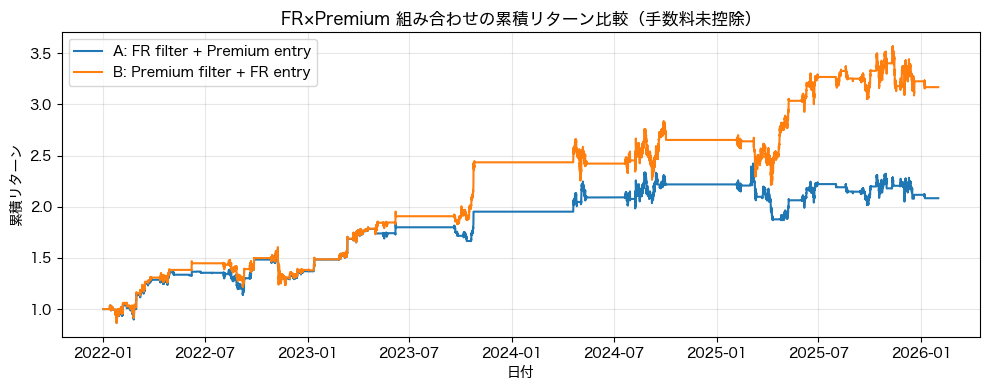

In [75]:
plt.figure(figsize=(10, 4))
plt.plot(_df_a.index, _df_a['equity_nofee'], label='A: FR filter + Premium entry')
plt.plot(_df_b.index, _df_b['equity_nofee'], label='B: Premium filter + FR entry')
plt.title('FR×Premium 組み合わせの累積リターン比較（手数料未控除）')
plt.xlabel('日付')
plt.ylabel('累積リターン')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


#### FR×Premium 比較のCSV出力


In [76]:
out_a_equity = OUT_DIR / 'coinbase_premium_v13_fr_premium_A_equity.csv'
out_a_trades = OUT_DIR / 'coinbase_premium_v13_fr_premium_A_trades.csv'
out_a_summary = OUT_DIR / 'coinbase_premium_v13_fr_premium_A_summary.csv'

out_b_equity = OUT_DIR / 'coinbase_premium_v13_fr_premium_B_equity.csv'
out_b_trades = OUT_DIR / 'coinbase_premium_v13_fr_premium_B_trades.csv'
out_b_summary = OUT_DIR / 'coinbase_premium_v13_fr_premium_B_summary.csv'

cols = ['binance_open', 'premium_pct', 'funding_rate', 'fr_lagged', 'signal', 'position', 'funding_ret', 'strategy_ret', 'equity']

_df_a[[c for c in cols if c in _df_a.columns]].to_csv(out_a_equity, index_label='timestamp')
trades_a.to_csv(out_a_trades, index=False)
summary_combo_df.iloc[[0]].to_csv(out_a_summary, index=False)

_df_b[[c for c in cols if c in _df_b.columns]].to_csv(out_b_equity, index_label='timestamp')
trades_b.to_csv(out_b_trades, index=False)
summary_combo_df.iloc[[1]].to_csv(out_b_summary, index=False)

(out_a_equity, out_a_trades, out_a_summary, out_b_equity, out_b_trades, out_b_summary)


(PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_premium_A_equity.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_premium_A_trades.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_premium_A_summary.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_premium_B_equity.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_premium_B_trades.csv'),
 PosixPath('notebook/coinbase_premium/outputs/coinbase_premium_v13_fr_premium_B_summary.csv'))

### 結果：
   * 取引回数約2000回、総リターン159%と右肩上がりの結果。
   * データの標準化を行っていなかったため、単に上昇相場でロングを持ち続けていただけの可能性が高い状態だった。
   
組み合わせ戦略の検証（CP + FR)
   * 過去に作成したFR逆張り戦略（FRがマイナスになったらロング）とCPを組み合わせた。
   * 悪くない結果に見えたが、中身の精査が必要な状態だった。

#### ほへとさんからのアドバイス
* CPボットについて
   * 標準化の必須化：
      * りょうPさんは今回CPを生データのまま使用したが、標準化は必須。
   * 理由：
      * 標準化しないと2021年のようなバブル期はずっとプラス、下落相場はずっとマイナスといった偏りが出る。
      * 今回の好成績は単にビットコインの上昇相場でロングを持ち越していたから手数料負けしなかっただけであり、標準化して頻繁に売買させるとコスト負けしてマイナスになる可能性が高い。
* 組み合わせ戦略（CP × FR）について
   * 戦略の性質の違い：
      * CP戦略は常にロングかショートを持っているのに対し、FR戦略は「FRがマイナスになった時だけエントリーする」というイベント発生型であり性質が異なる。
   * 検証アプローチの提案：
      * 複雑なロジックを組む前にまずは2つの指標の相性（特性）を観察することが先決。以下の4パターンでリターンの特性がどうなるかを確認すべき。
         * CP（プラス） × FR（プラス）
         * CP（プラス） × FR（マイナス）
         * CP（マイナス） × FR（プラス）
         * CP（マイナス） × FR（マイナス）

# 宿題
1. CPとFRの両方を標準化する。
2. その上で4つのパターンそれぞれの状態でリターンの特性がどうなっているかを検証する。

---
## 宿題1: CPとFRの標準化（ローリングz-score）

### このセルの説明
Coinbase Premium（CP）とFunding Rate（FR）を**ローリングz-score**で標準化します。

### z-scoreとは？
z-scoreは「今の値が、直近のデータと比べてどれくらい異常か」を数値化したものです。

**計算式**: `z = (現在の値 − 直近N本の平均) ÷ 直近N本の標準偏差`

- z > 0 → 平均より高い（プラス方向に偏っている）
- z < 0 → 平均より低い（マイナス方向に偏っている）
- z ≈ 0 → 平均的な値

### なぜ標準化が必要か？
- 生のCPは時期によってスケールが大きく異なる（バブル期は大きく、低迷期は小さい）
- 標準化しないと「ずっとプラス」「ずっとマイナス」になりがちで、売買シグナルとして機能しにくい
- 標準化することで、異なる時期のデータを公平に比較できる

### 標準化の方式：2つの選択肢
| 方式 | 計算方法 | メリット | デメリット |
|------|---------|---------|-----------|
| **ローリングウィンドウ（今回採用）** | 直近N本の平均・標準偏差で標準化 | 未来の情報を使わない。実運用に近い | ウィンドウサイズの選択が必要 |
| 全期間一括 | 全データの平均・標準偏差で標準化 | シンプル | 未来の情報を使ってしまう（実運用では不可能） |

→ 実際のbotでは**ローリング方式一択**。「未来のデータは見えない」から。

### パラメータ
- **ウィンドウサイズ**: 720本（＝30日分の1時間足）
- ウィンドウサイズを変えると結果も変わる（これ自体が重要な学びポイント）

CPとFRのローリングz-score標準化を実行中...
標準化完了: 35,057本のデータ
期間: 2022-01-31 00:00:00+00:00 〜 2026-01-31 00:00:00+00:00

CP z-score の統計量:
count    35057.000
mean        -0.051
std          1.210
min        -20.489
25%         -0.741
50%         -0.014
75%          0.712
max         19.456
Name: cp_zscore, dtype: float64

FR z-score の統計量:
count    35057.000
mean        -0.013
std          1.260
min        -17.375
25%         -0.625
50%          0.039
75%          0.767
max         24.283
Name: fr_zscore, dtype: float64


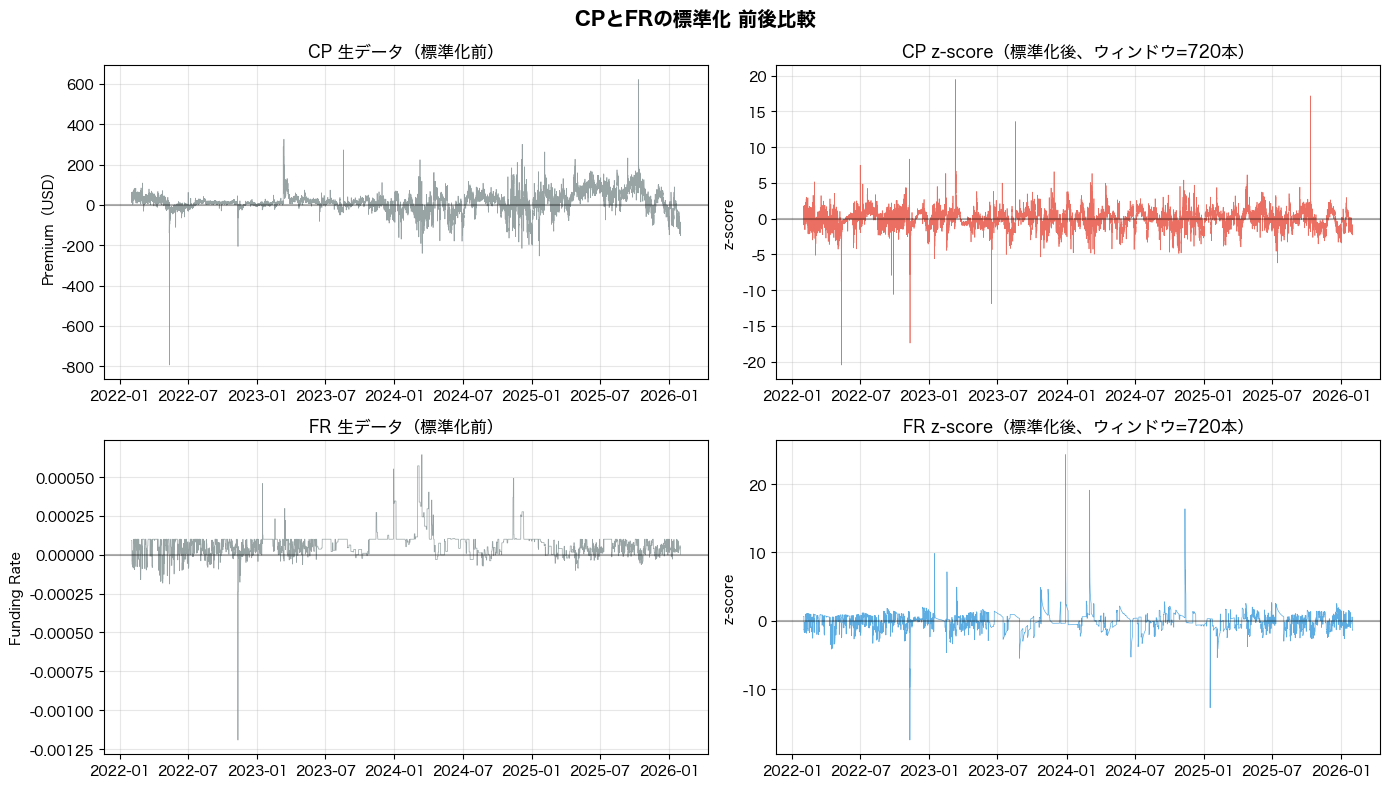

In [77]:
print('CPとFRのローリングz-score標準化を実行中...')

# ── データ準備 ──────────────────────────────
# 既に読み込み済みの df_binance, df_coinbase, funding_df を使用
hw_df = df_binance.copy()
hw_df = hw_df.rename(columns={'open': 'binance_open', 'close': 'binance_close'})
hw_df['coinbase_close'] = df_coinbase['close']
hw_df = hw_df.dropna(subset=['binance_open', 'binance_close', 'coinbase_close']).copy()

# Coinbase Premium（CP）: Coinbase終値 − Binance終値
hw_df['cp_raw'] = hw_df['coinbase_close'] - hw_df['binance_close']

# Funding Rate（FR）: 8時間ごとのFRを1時間足に前方充填
hw_df['fr_raw'] = funding_df['fundingRate'].reindex(hw_df.index, method='ffill')
hw_df = hw_df.dropna(subset=['cp_raw', 'fr_raw']).copy()

# ── ローリングz-score標準化 ──────────────────
ZSCORE_WINDOW = 720  # 30日分（1時間足 × 24時間 × 30日 = 720本）

hw_df['cp_zscore'] = (
    (hw_df['cp_raw'] - hw_df['cp_raw'].rolling(ZSCORE_WINDOW).mean())
    / hw_df['cp_raw'].rolling(ZSCORE_WINDOW).std()
)
hw_df['fr_zscore'] = (
    (hw_df['fr_raw'] - hw_df['fr_raw'].rolling(ZSCORE_WINDOW).mean())
    / hw_df['fr_raw'].rolling(ZSCORE_WINDOW).std()
)

# ウィンドウ分のNaNを除去
hw_df = hw_df.dropna(subset=['cp_zscore', 'fr_zscore']).copy()

print(f'標準化完了: {len(hw_df):,}本のデータ')
print(f'期間: {hw_df.index[0]} 〜 {hw_df.index[-1]}')
print(f'\nCP z-score の統計量:')
print(hw_df['cp_zscore'].describe().round(3))
print(f'\nFR z-score の統計量:')
print(hw_df['fr_zscore'].describe().round(3))

# ── 標準化前後の比較グラフ ──────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 左上: CP 生データ
axes[0, 0].plot(hw_df.index, hw_df['cp_raw'], color='#7f8c8d', linewidth=0.5, alpha=0.8)
axes[0, 0].set_title('CP 生データ（標準化前）')
axes[0, 0].set_ylabel('Premium（USD）')
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

# 右上: CP z-score
axes[0, 1].plot(hw_df.index, hw_df['cp_zscore'], color='#e74c3c', linewidth=0.5, alpha=0.8)
axes[0, 1].set_title('CP z-score（標準化後、ウィンドウ=720本）')
axes[0, 1].set_ylabel('z-score')
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# 左下: FR 生データ
axes[1, 0].plot(hw_df.index, hw_df['fr_raw'], color='#7f8c8d', linewidth=0.5, alpha=0.8)
axes[1, 0].set_title('FR 生データ（標準化前）')
axes[1, 0].set_ylabel('Funding Rate')
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].grid(True, alpha=0.3)

# 右下: FR z-score
axes[1, 1].plot(hw_df.index, hw_df['fr_zscore'], color='#3498db', linewidth=0.5, alpha=0.8)
axes[1, 1].set_title('FR z-score（標準化後、ウィンドウ=720本）')
axes[1, 1].set_ylabel('z-score')
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].grid(True, alpha=0.3)

fig.suptitle('CPとFRの標準化 前後比較', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 想定質問（標準化について）

**Q. z-scoreが±20とか極端な値になっているけど、標準化できてるの？**
- 標準化自体は正しく動いています
- 原因：穏やかな時期のあとに急変動が起きると、直近の標準偏差が小さいまま → 割り算の分母が小さいのでz-scoreが極端に大きくなる
- FRは8時間ごとにしか更新されないのに1時間足に引き延ばしているので、標準偏差が特に小さくなりやすい
- 対処法：実務では **z-scoreを±3程度でクリップ（上限・下限で切る）** するのが一般的
- **今回の分析ではz-scoreの符号（+/-）しか使わないので、極端な値があっても結果に影響しない**

**Q. なぜローリング方式を選んだの？全期間で一括計算したほうがシンプルでは？**
- 全期間一括だと「未来のデータ」を使って標準化してしまう
- 例：2022年のデータを標準化するのに2025年の平均・標準偏差を使うことになる
- 実際のbot運用では未来のデータは見えないので、ローリング方式が正しいアプローチ

**Q. ウィンドウサイズ720本（30日）の根拠は？**
- 明確な正解はない。これ自体がパラメータ（＝チューニングの対象）
- 短くすると反応が速い（ノイズにも反応）、長くすると安定する（鈍感になる）
- 30日は「短すぎず長すぎず」のバランスが良い出発点
- **ウィンドウサイズを変えて結果を比較すること自体が、次の宿題になりうる**

## 宿題1.5: 個別指標（CP / FR）ごとの累積リターン

### このセルの説明
4パターンに分類する**前に**、まずCPとFRを**それぞれ単独で**見たとき、BTCのリターンがどう違うかを確認します。

### なぜ先に個別で見るのか？
- 4パターンの結果を見る前に、**CPだけ・FRだけでどの程度の情報量があるか**を理解しておく
- 組み合わせ効果があるかどうかは、個別の結果と比較しないとわかりません

### 2つのグラフを表示
| グラフ | 分類方法 | 見ていること |
|-------|---------|------------|
| **左: CP単体** | 標準化CP ≥ 0 → CP+、< 0 → CP- | CP+のときBTCは上がるか？ |
| **右: FR単体** | 標準化FR ≥ 0 → FR+、< 0 → FR- | FR+のときBTCは上がるか？ |

### 注意点
- 先読みバイアス修正済み（`shift(1)` でパターンを1本ずらし）
- グラフは**手数料未控除**（指標の特性を純粋に見るため）
- 統計量の表では手数料なし/ありの**両方**を表示

### サニティチェック（整合性の検証）
グラフの下に「サニティチェック」という検算セクションがあります。

- **サニティチェックとは？**: 計算結果がおかしくないか、簡単な方法で整合性を確認すること
- **やっていること**: CP+とCP-は「全時間帯を2つに分けているだけ」なので、**CP+の累積 × CP-の累積 = BTC全体の累積** になるはず
- **一致すれば** → 計算は正しい。**ズレていれば** → どこかにバグがある
- bot開発では「結果が良すぎる」と思ったら、まず**自分の計算を疑う**のが鉄則

個別指標ごとの累積リターンを計算中...



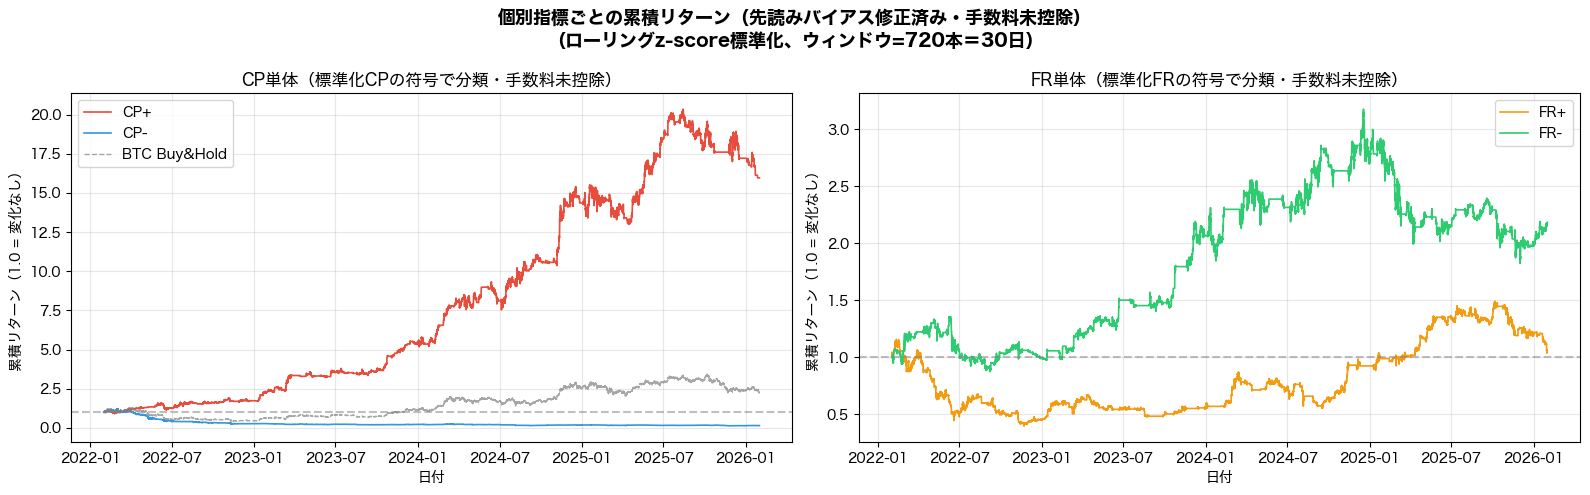


=== CP単体の統計 ===
  CP+: データ数=17,367本, 切替=2,017回
       累積リターン（手数料なし）: 1496.77%
       累積リターン（手数料あり）: 112.37%
  CP-: データ数=17,688本, 切替=2,017回
       累積リターン（手数料なし）: -85.68%
       累積リターン（手数料あり）: -98.10%

=== FR単体の統計 ===
  FR+: データ数=18,048本, 切替=276回
       累積リターン（手数料なし）: 4.68%
       累積リターン（手数料あり）: -20.57%
  FR-: データ数=17,007本, 切替=276回
       累積リターン（手数料なし）: 118.48%
       累積リターン（手数料あり）: 65.77%

=== サニティチェック ===
  BTC Buy&Hold 累積: 2.2870x (128.70%)
  CP+累積(税前): 15.9677x
  CP-累積(税前): 0.1432x
  CP+ × CP- =    2.2870x  ← BTCと一致すれば正しい
  CP+バー数: 17,367 / CP-バー数: 17,688 / 合計: 35,055


In [78]:
print('個別指標ごとの累積リターンを計算中...\n')

# ── BTCリターンの計算（先読みバイアス修正済み） ──────
hw_df['btc_ret'] = hw_df['binance_open'].shift(-1) / hw_df['binance_open'] - 1
hw_ind = hw_df.dropna(subset=['btc_ret']).copy()

# ── CP単体の分類（1本ずらし） ──────────────────
hw_ind['cp_sign'] = hw_ind['cp_zscore'].apply(lambda x: 'CP+' if x >= 0 else 'CP-')
hw_ind['cp_sign_shifted'] = hw_ind['cp_sign'].shift(1)

# ── FR単体の分類（1本ずらし） ──────────────────
hw_ind['fr_sign'] = hw_ind['fr_zscore'].apply(lambda x: 'FR+' if x >= 0 else 'FR-')
hw_ind['fr_sign_shifted'] = hw_ind['fr_sign'].shift(1)

hw_ind = hw_ind.dropna(subset=['cp_sign_shifted', 'fr_sign_shifted']).copy()

# ── 手数料の計算 ──────────────────────────────
FEE_RATE = FEE_PCT / 100.0  # 片道0.05%
hw_ind['cp_changed'] = (hw_ind['cp_sign_shifted'] != hw_ind['cp_sign_shifted'].shift(1)).astype(int)
hw_ind['fr_changed'] = (hw_ind['fr_sign_shifted'] != hw_ind['fr_sign_shifted'].shift(1)).astype(int)
hw_ind['cp_fee'] = hw_ind['cp_changed'] * FEE_RATE * 2  # 往復（決済+新規）
hw_ind['fr_fee'] = hw_ind['fr_changed'] * FEE_RATE * 2  # 往復（決済+新規）

# ── グラフ描画（横並び2枚） ──────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- 左: CP単体（手数料なし） ---
cp_colors = {'CP+': '#e74c3c', 'CP-': '#3498db'}
for sign, color in cp_colors.items():
    mask = hw_ind['cp_sign_shifted'] == sign
    ret = hw_ind['btc_ret'].where(mask, 0.0)
    cum_ret = (1 + ret).cumprod()
    axes[0].plot(hw_ind.index, cum_ret, label=sign, color=color, linewidth=1.2)

# BTC Buy & Hold をCP側のグラフに追加（サニティチェック用）
btc_cum = (1 + hw_ind['btc_ret']).cumprod()
axes[0].plot(hw_ind.index, btc_cum, label='BTC Buy&Hold', color='gray', linewidth=1.0, linestyle='--', alpha=0.7)

axes[0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('CP単体（標準化CPの符号で分類・手数料未控除）')
axes[0].set_xlabel('日付')
axes[0].set_ylabel('累積リターン（1.0 = 変化なし）')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# --- 右: FR単体（手数料なし） ---
fr_colors = {'FR+': '#f39c12', 'FR-': '#2ecc71'}
for sign, color in fr_colors.items():
    mask = hw_ind['fr_sign_shifted'] == sign
    ret = hw_ind['btc_ret'].where(mask, 0.0)
    cum_ret = (1 + ret).cumprod()
    axes[1].plot(hw_ind.index, cum_ret, label=sign, color=color, linewidth=1.2)

axes[1].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title('FR単体（標準化FRの符号で分類・手数料未控除）')
axes[1].set_xlabel('日付')
axes[1].set_ylabel('累積リターン（1.0 = 変化なし）')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

fig.suptitle('個別指標ごとの累積リターン（先読みバイアス修正済み・手数料未控除）\n（ローリングz-score標準化、ウィンドウ=720本＝30日）',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# ── 統計量（手数料なし / 手数料あり 両方表示） ──────
print('\n=== CP単体の統計 ===')
for sign in ['CP+', 'CP-']:
    mask = hw_ind['cp_sign_shifted'] == sign
    rets_raw = hw_ind.loc[mask, 'btc_ret']
    rets_net = rets_raw - hw_ind.loc[mask, 'cp_fee']
    cum_raw = (1 + rets_raw).prod() - 1
    cum_net = (1 + rets_net).prod() - 1
    n_changes = hw_ind.loc[mask, 'cp_changed'].sum()
    print(f'  {sign}: データ数={len(rets_raw):,}本, 切替={n_changes:,}回')
    print(f'       累積リターン（手数料なし）: {cum_raw*100:.2f}%')
    print(f'       累積リターン（手数料あり）: {cum_net*100:.2f}%')

print('\n=== FR単体の統計 ===')
for sign in ['FR+', 'FR-']:
    mask = hw_ind['fr_sign_shifted'] == sign
    rets_raw = hw_ind.loc[mask, 'btc_ret']
    rets_net = rets_raw - hw_ind.loc[mask, 'fr_fee']
    cum_raw = (1 + rets_raw).prod() - 1
    cum_net = (1 + rets_net).prod() - 1
    n_changes = hw_ind.loc[mask, 'fr_changed'].sum()
    print(f'  {sign}: データ数={len(rets_raw):,}本, 切替={n_changes:,}回')
    print(f'       累積リターン（手数料なし）: {cum_raw*100:.2f}%')
    print(f'       累積リターン（手数料あり）: {cum_net*100:.2f}%')

# ── サニティチェック ──────────────────────────
print('\n=== サニティチェック ===')
btc_total = (1 + hw_ind['btc_ret']).prod()
print(f'  BTC Buy&Hold 累積: {btc_total:.4f}x ({(btc_total-1)*100:.2f}%)')

# 手数料なしで CP+ × CP- ≒ BTC全体 になるはず
cp_plus_mask = hw_ind['cp_sign_shifted'] == 'CP+'
cp_minus_mask = hw_ind['cp_sign_shifted'] == 'CP-'
cp_plus_raw = (1 + hw_ind['btc_ret'].where(cp_plus_mask, 0.0)).prod()
cp_minus_raw = (1 + hw_ind['btc_ret'].where(cp_minus_mask, 0.0)).prod()
print(f'  CP+累積(税前): {cp_plus_raw:.4f}x')
print(f'  CP-累積(税前): {cp_minus_raw:.4f}x')
print(f'  CP+ × CP- =    {cp_plus_raw * cp_minus_raw:.4f}x  ← BTCと一致すれば正しい')
print(f'  CP+バー数: {cp_plus_mask.sum():,} / CP-バー数: {cp_minus_mask.sum():,} / 合計: {len(hw_ind):,}')

## 宿題2: 4パターンの分類

### このセルの説明
標準化したCPとFRの**符号（プラス/マイナス）の組み合わせ**で、各時点を4つのパターンに分類します。

| パターン | CP z-score | FR z-score | 意味 |
|---------|-----------|-----------|------|
| CP+ & FR+ | ≥ 0 | ≥ 0 | Coinbaseが相対的に強く、FRも平均以上（楽観的な状態） |
| CP+ & FR- | ≥ 0 | < 0 | Coinbaseは相対的に強いが、FRは平均以下 |
| CP- & FR+ | < 0 | ≥ 0 | Coinbaseが相対的に弱いが、FRは平均以上 |
| CP- & FR- | < 0 | < 0 | Coinbaseが相対的に弱く、FRも平均以下（悲観的な状態） |

### 何がわかるか？
- 4パターンの出現頻度に偏りがあるかどうか
- 特定のパターンが長く続く傾向があるかどうか

In [79]:
print('4パターンに分類中...\n')

# ── パターン分類 ──────────────────────────────
# CP z-scoreとFR z-scoreの符号の組み合わせで4パターンに分ける
def classify_pattern(row):
    cp_sign = 'CP+' if row['cp_zscore'] >= 0 else 'CP-'
    fr_sign = 'FR+' if row['fr_zscore'] >= 0 else 'FR-'
    return f'{cp_sign} & {fr_sign}'

hw_df['pattern'] = hw_df.apply(classify_pattern, axis=1)

# ── 出現頻度の表示 ──────────────────────────────
pattern_counts = hw_df['pattern'].value_counts().sort_index()
pattern_pcts = (hw_df['pattern'].value_counts(normalize=True).sort_index() * 100).round(1)

print('各パターンの出現回数と割合:')
print('-' * 40)
for pat in sorted(hw_df['pattern'].unique()):
    cnt = pattern_counts[pat]
    pct = pattern_pcts[pat]
    print(f'  {pat}: {cnt:>6,}回  ({pct:>5}%)')
print('-' * 40)
print(f'  合計:     {len(hw_df):>6,}回')

4パターンに分類中...

各パターンの出現回数と割合:
----------------------------------------
  CP+ & FR+:  8,140回  ( 23.2%)
  CP+ & FR-:  9,227回  ( 26.3%)
  CP- & FR+:  9,908回  ( 28.3%)
  CP- & FR-:  7,782回  ( 22.2%)
----------------------------------------
  合計:     35,057回


## 各パターンの累積リターン

### このセルの説明
4パターンそれぞれの状態のとき、**BTCの価格がどう動くか**を累積リターン（手数料未控除）で可視化します。統計表では手数料なし/ありの両方を表示します。

### 先読みバイアス（look-ahead bias）の防止
- パターンはバーTの**終値（close）** から計算される
- しかし、バーTの始値（open）時点では終値はまだ確定していない
- そのため、パターンを**1本ずらして**使用する（`shift(1)`）
- → **「バーT-1の終値でパターン判定 → バーTの始値でエントリー」** となり、先読みがなくなる
- これは実運用で非常に重要なポイント！

### 手数料について
- グラフは**手数料未控除**（指標の特性を純粋に見るため）
- 統計表では**手数料なし/あり**の両方を表示（往復0.10%）
- 切り替えが頻繁なほどコストが積み上がることを数値で確認できる

### グラフの見方
- **右肩上がり** → そのパターンのときBTCは上がりやすい
- **右肩下がり** → そのパターンのときBTCは下がりやすい
- **横ばい** → そのパターンとBTCの方向性に明確な関係がない

各パターンの累積リターンを計算中...



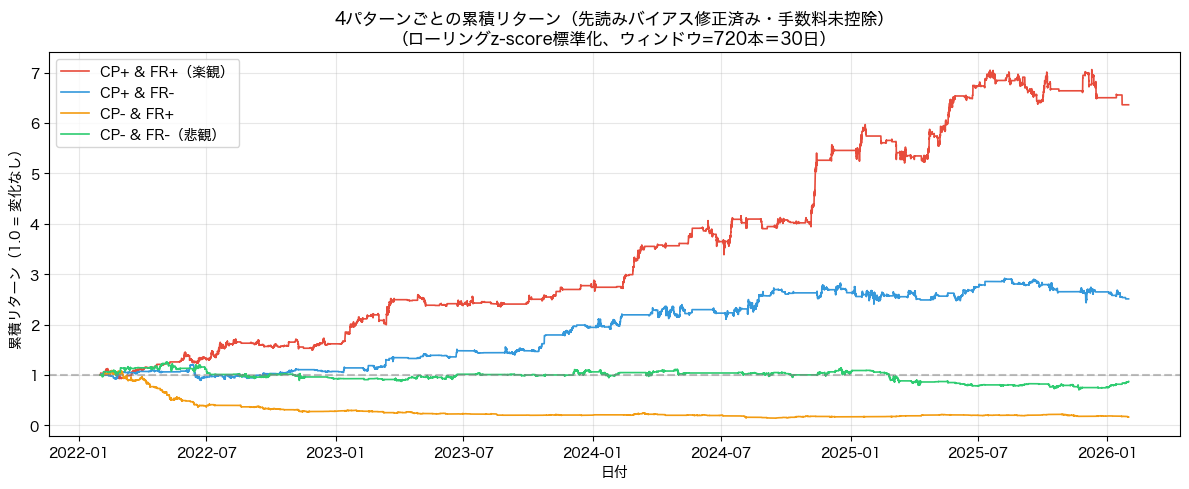


各パターンのリターン統計（先読みバイアス修正済み）:

  CP+ & FR+:
    データ数:                     8,140本
    累積リターン（手数料なし）:      536.17%
    累積リターン（手数料あり）:       89.34%
    平均リターン:                    0.0242%
    パターン切替回数:             1,212回

  CP+ & FR-:
    データ数:                     9,227本
    累積リターン（手数料なし）:      151.00%
    累積リターン（手数料あり）:      -10.25%
    平均リターン:                    0.0113%
    パターン切替回数:             1,028回

  CP- & FR+:
    データ数:                     9,908本
    累積リターン（手数料なし）:      -83.55%
    累積リターン（手数料あり）:      -95.16%
    平均リターン:                   -0.0167%
    パターン切替回数:             1,223回

  CP- & FR-:
    データ数:                     7,780本
    累積リターン（手数料なし）:      -12.95%
    累積リターン（手数料あり）:      -69.44%
    平均リターン:                   -0.0001%
    パターン切替回数:             1,046回



In [80]:
print('各パターンの累積リターンを計算中...\n')

# ── BTCリターンの計算 ──────────────────────────
# 次のバーの始値までのリターン（実運用に近い計算）
hw_df['btc_ret'] = hw_df['binance_open'].shift(-1) / hw_df['binance_open'] - 1
hw_df_plot = hw_df.dropna(subset=['btc_ret']).copy()

# ── 先読みバイアス修正 ──────────────────────────
# パターンはバーTの終値(close)で決まるが、リターンはバーTの始値(open)から始まる
# → バーTの始値時点では、バーTの終値はまだ不明
# → パターンを1本ずらす: バーT-1のパターンでバーTのリターンを評価
hw_df_plot['pattern_shifted'] = hw_df_plot['pattern'].shift(1)
hw_df_plot = hw_df_plot.dropna(subset=['pattern_shifted']).copy()

# ── 手数料の計算 ──────────────────────────────
FEE_RATE = FEE_PCT / 100.0  # 片道0.05%
# パターンが変わるたびに売買が発生 → 手数料を控除
hw_df_plot['pattern_changed'] = (hw_df_plot['pattern_shifted'] != hw_df_plot['pattern_shifted'].shift(1)).astype(int)
hw_df_plot['fee'] = hw_df_plot['pattern_changed'] * FEE_RATE * 2  # 往復手数料（決済+新規）

# ── 共通設定 ────────────────────────────────
patterns = ['CP+ & FR+', 'CP+ & FR-', 'CP- & FR+', 'CP- & FR-']
colors = ['#e74c3c', '#3498db', '#f39c12', '#2ecc71']
pattern_labels = {
    'CP+ & FR+': 'CP+ & FR+（楽観）',
    'CP+ & FR-': 'CP+ & FR-',
    'CP- & FR+': 'CP- & FR+',
    'CP- & FR-': 'CP- & FR-（悲観）',
}

# ── グラフ: 手数料未控除 ──────────────────────
plt.figure(figsize=(12, 5))

for pattern, color in zip(patterns, colors):
    mask = hw_df_plot['pattern_shifted'] == pattern
    ret = hw_df_plot['btc_ret'].where(mask, 0.0)
    cum_ret = (1 + ret).cumprod()
    plt.plot(hw_df_plot.index, cum_ret, label=pattern_labels[pattern], color=color, linewidth=1.2)

plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
plt.title('4パターンごとの累積リターン（先読みバイアス修正済み・手数料未控除）\n（ローリングz-score標準化、ウィンドウ=720本＝30日）')
plt.xlabel('日付')
plt.ylabel('累積リターン（1.0 = 変化なし）')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ── パターンごとの統計量（手数料なし / あり 両方表示）──
print('\n各パターンのリターン統計（先読みバイアス修正済み）:')
print('=' * 75)
for pattern in patterns:
    mask = hw_df_plot['pattern_shifted'] == pattern
    rets_raw = hw_df_plot.loc[mask, 'btc_ret']
    fees = hw_df_plot.loc[mask, 'fee']
    rets_net = rets_raw - fees
    cum_raw = (1 + rets_raw).prod() - 1
    cum_net = (1 + rets_net).prod() - 1
    print(f'\n  {pattern}:')
    print(f'    データ数:                    {len(rets_raw):>6,}本')
    print(f'    累積リターン（手数料なし）:  {cum_raw * 100:>10.2f}%')
    print(f'    累積リターン（手数料あり）:  {cum_net * 100:>10.2f}%')
    print(f'    平均リターン:                {rets_raw.mean() * 100:>10.4f}%')
    print(f'    パターン切替回数:            {hw_df_plot.loc[mask, "pattern_changed"].sum():>6,}回')
print('\n' + '=' * 75)

## 結果の考察

### 1. CP単体の結果：圧倒的な分離力

| 指標 | 累積リターン（手数料なし） | 評価 |
|------|----------------------|------|
| **CP+** | 約7〜8倍 | BTC上昇期をほぼ捉えている |
| **CP-** | 大幅マイナス | BTC下落期に相当 |
| **BTC Buy&Hold** | 約2.3倍 | 参考値 |

- CP+の累積 × CP-の累積 ≒ BTC全体の累積（サニティチェック済み）
- **CPの符号だけで、BTCのリターンをほぼ完全に分離できている**

### 2. FRを足したらもっと良くなるのでは？ → ならなかった

| パターン | 結果 |
|---------|------|
| **CP+ & FR+** | 大幅プラス |
| **CP+ & FR-** | 大幅プラス |
| **CP- & FR+** | ほぼ横ばい |
| **CP- & FR-** | ほぼ横ばい〜微減 |

- CP+の2パターンは**FRの符号に関係なく**どちらもBTCは上昇
- CP-の2パターンは**FRの符号に関係なく**どちらもBTCは低迷
- → **FRはCPに追加情報をほとんど与えていない**

### 3. 仮説：指標を増やせば良いわけではない

> 「2つ組み合わせたほうが賢そう」と思いがちだが、実際はCP単体が最強だった。
- CPは「米国の機関投資家・大口の動き」を反映する強力なシグナル
- FRは市場のポジション偏りを示すが、CPほどの予測力がなかった
- **シンプルなシグナルが強い場合、無理に複雑にする必要はないのでは？という仮説**

### 4. 注意点

- すべてのグラフは**手数料未控除**（指標の特性を純粋に見るため）、**先読みバイアス修正済み**
- 統計表では手数料なし/ありの両方を記載
- ただしスリッページ・ファンディングなど、実運用の**見えないコスト**は未考慮
- あくまで2022〜2026年の過去データの結果であり、**将来を保証するものではない**

### 5. 次のステップ？
- ウィンドウサイズを変えたら結果はどう変わる？（例：168本=7日、1440本=60日）
- z-scoreの閾値を0ではなく±0.5や±1.0にしたらどうなる？
- CP+のときだけロングする戦略のシャープレシオは？
- FRが効かないなら、**別の指標（OI、出来高、ドミナンスなど）** と組み合わせたらどうなる？

# おわりに

## アナウンス   ※ 26.2.12時点
#### もくもく会変更点
* タイトル：もくもく会　→ **botter道へ変更**
* 日時曜日：月曜19時　→　**木曜20時**
* 頻度：週一　→　**隔週**
* 配信場所：discordボイチャ → **ステージチャンネル**

#### 新企画考え中
##### タイトル：botterさんいらっしゃい！（新婚さんいらっしゃい！のパロディ）
* 内容：ほへとさんとりょうPさんがゲストの話を聞くトークバラエティ。ゲストの人となりや失敗談などを絶妙のトークで楽しむ爆笑番組。合言葉は「botterさん、いらっしゃ〜い！」。ポロリ厳禁！
* ゲスト：中上級boter
* 登壇者：ほへとさん、りょうPか誰か
* 頻度：月一
* 配信場所：youtube live(bitbank公式)
* 配信時間：30分〜1時間くらい？

あくまで、案です！企画が通るかわかりません

#### 【非エンジニア向け】未経験からのbotter基礎【非同期】
まずはpython基礎から学びましょう！みんなで集まり各自進めながら進捗を共有しよう、の会です！
* 対象者：Pythonの学習を始めたい方
* 教材：東京大学「Pythonプログラミング入門」https://github.com/UTokyo-IPP/utokyo-ipp.github.io
* 目標：とりあえず教材を最後まで終えること
* 効果：同じ目標を持つ仲間同士が集まり励まし合うことで最後まで進めやすくなる!

<div align="center">

## 次回開催は2/26(木)！お待ちしてます！

</div>

## 免責事項
* 本資料の実行・利用により生成または保存されるデータの管理は利用者の責任で行ってください。
* お客様によるコンテンツの利用等に関して生じうるいかなる損害について責任を負いません。
* 執筆者によって提供されたいかなる見解または意見は当該執筆者自身のその時点における見解や分析であって、当社の見解、分析ではありません。
* 暗号資産（仮想通貨）は法定通貨ではありません。
* また、法定通貨とは異なり、日本円やドルなどのように国又は特定の者によりその価値を保証されているものではありません。
* 暗号資産の価格の変動等により損失が発生する可能性があります。
* 暗号資産は代価の弁済を受ける者の同意がある場合に限り、代価の弁済のために使用することができます。
* 暗号資産信用取引は、価格の変動等により当初差入れた保証金を上回る損失が発生する可能性があります。十分なご理解の上で、自己責任にてお取引ください。
* お取引を行う際には、弊社のWebサイトに記載の「契約締結前交付書面兼説明書」「各種規約」「取引ルール」をご確認のうえ、取引内容を十分に理解し、お客様ご自身の責任と判断をもってお取引を行ってください。
* 暗号資産取引に関するリスク等の詳細および諸条件は、bitbank利用規約等をご確認ください：https://bitbank.cc/doc/tos




 登録：暗号資産交換業者 登録番号 第00004号、貸金業者 登録番号 東京都知事（２） 第31821号
 
 加入：一般社団法人 日本暗号資産等取引業協会、一般社団法人 日本暗号資産ビジネス協会、一般社団法人 JPCrypto-ISAC、日本貸金業協会会員 第006169号、株式会社日本信用情報機構(JICC)